# Heat Flux Feature Imputation

**Context**: This dataset was prepared for the journal article entitled _"On the prediction of critical heat flux using a physics-informed machine learning-aided framework"_ (doi: 10.1016/j.applthermaleng.2019.114540). The dataset contains processed and compiled records of experimental critical heat flux and boundary conditions used for the work presented in the article.

**Goal**: Through the provided features impute the `x_e_out [-]`.

**Feature Description**:
- Geometry[-]: geometry of the heat source
- Pressure [Mpa]: Pressure inside the boiler
- Length [mm]: the heated length of the heat source
- Dh [mm]: channel heated diameter
- De [mm]: channel equivalent (or hydraulic) diameter
- chf_exp: Experimental critical heat flux [MW/m2]
- mass_flux [kg/m2 s]: In physics and engineering, mass flux is the rate of mass flow
- x_e [-]: loca/exit equilibrium (or thermodynamic) quality

**Resources**:
- [Kaggle Challenge](https://www.kaggle.com/competitions/playground-series-s3e15/overview)
- [Dataset](https://www.kaggle.com/datasets/saurabhshahane/predicting-heat-flux)

In [120]:
# Import Standard Libraries
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import seaborn as sns

import mlflow

from pathlib import Path
from colorama import Style, Fore

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, LearningCurveDisplay, \
                                    learning_curve, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from scipy import stats

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

# Read Data

In [4]:
# Switch flag for Kaggle Cloud
kaggle = False

# Switch flag for including original dataset
include_original_data = True

In [5]:
# Read training data
if kaggle:
    
    # Read data from Kaggle FS
    data = pd.read_csv('/kaggle/input/playground-series-s3e15/data.csv')
    original_data = pd.read_csv('/kaggle/input/originacsv/heat_flux_feature_imputation_original.csv')
    
else:
    
    # Define local data file paths
    data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E15' / 'heat_flux_feature_imputation_data.csv'
    original_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E15' / 'heat_flux_feature_imputation_original.csv'
   
    data = pd.read_csv(data_file_path, index_col=0)
    original_data = pd.read_csv(original_data_file_path, index_col=0)

In [6]:
data.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31644 entries, 0 to 31643
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author               26620 non-null  object 
 1   geometry             26144 non-null  object 
 2   pressure [MPa]       27192 non-null  float64
 3   mass_flux [kg/m2-s]  26853 non-null  float64
 4   x_e_out [-]          21229 non-null  float64
 5   D_e [mm]             26156 non-null  float64
 6   D_h [mm]             27055 non-null  float64
 7   length [mm]          26885 non-null  float64
 8   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.4+ MB


Since there are some null values in the `x_e_out [-]`, the data would be splitted as follow:
- Train Data: entries with `x_e_out [-]` non-null
- Test Data: entries with `x_e_out [-]` null

## Define Train and Test Data

In [8]:
# Define train_data
train_data = data[data['x_e_out [-]'].notnull()]

In [9]:
# Define test_data
test_data = data[data['x_e_out [-]'].isnull()]

# Exploratory Data Analysis (EDA)

In [23]:
# Define dictionary of data to plot
data_to_plot = {'Train': train_data, 
                'Test': test_data, 
                'Original': original_data}

## Shapes Information

In [10]:
# Print shapes information
print(f'{blue}Data Shapes:'
      f'{blue}\n- Train Data     -> {red}{train_data.shape}'
      f'{blue}\n- Original Data  -> {red}{original_data.shape}'
      f'{blue}\n- Test Data      -> {red}{test_data.shape}\n')

Data Shapes:
- Train Data     -> (21229, 9)
- Original Data  -> (1865, 9)
- Test Data      -> (10415, 9)



## Null Values Information

In [11]:
# Print null values information
print(f'{blue}Data Columns with Null Values:'
      f'{blue}\n- Train Data     -> {red}{train_data.isnull().any().sum()}'
      f'{blue}\n- Original Data  -> {red}{original_data.isnull().any().sum()}'
      f'{blue}\n- Test Data      -> {red}{test_data.isnull().any().sum()}\n')

Data Columns with Null Values:
- Train Data     -> 7
- Original Data  -> 0
- Test Data      -> 8



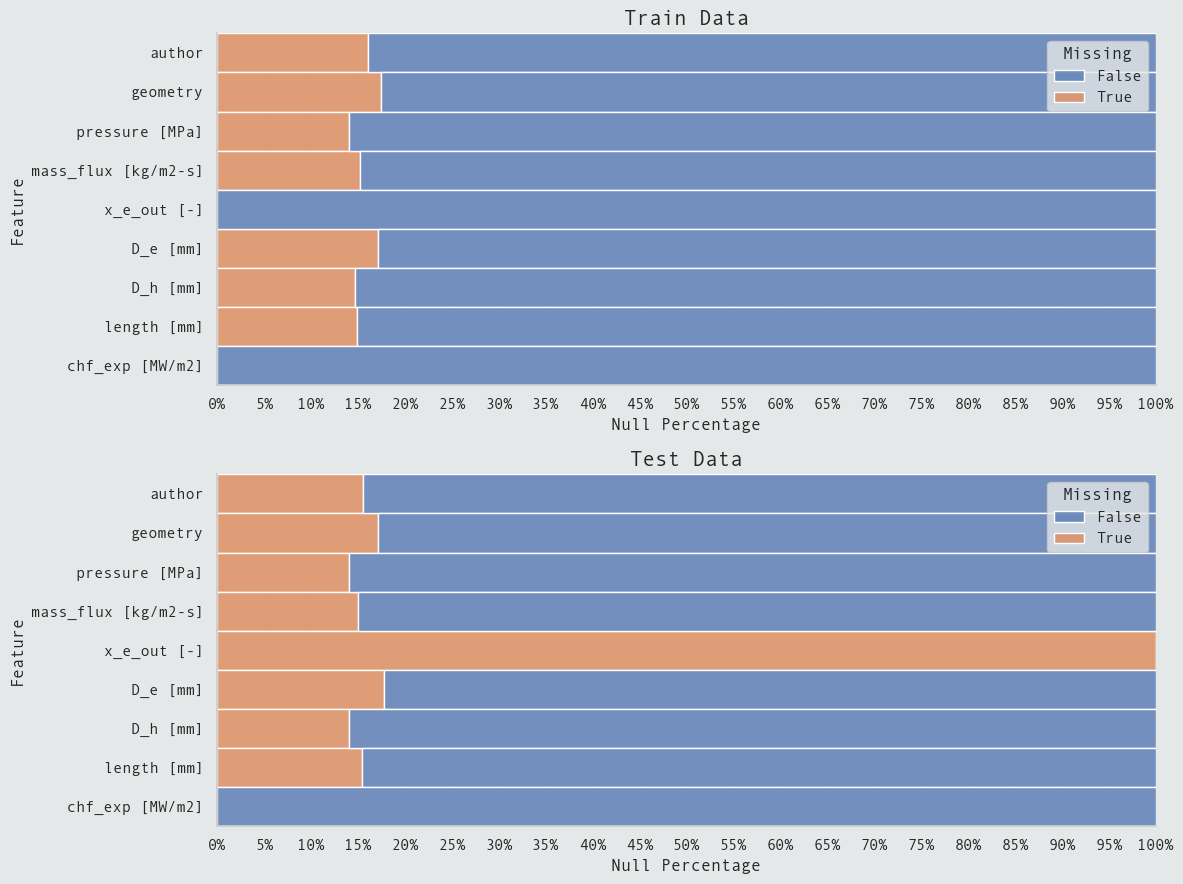

In [12]:
# Define data to display
data_to_display = {
    'Train Data': train_data,
    'Test Data': test_data
}

# Create figure
figure = plt.figure(tight_layout=True, figsize=(12, 9))

# Define figure's subplots
grid_spec = GridSpec(len(data_to_display), 1)

# Fetch data to plot
for row, (name, dataframe) in enumerate(data_to_display.items()):
    
    # Create subplot
    ax = figure.add_subplot(grid_spec[row, 0])
    
    sns.histplot(data=dataframe.isna().melt(var_name='Feature', value_name='Missing'), 
                 y='Feature', 
                 hue='Missing', 
                 multiple='fill',
                 ax=ax)
    
    # Refactor x label as missing percentage
    ax.xaxis.set_major_locator(ticker.LinearLocator(21))
    ax.xaxis.set_major_formatter('{:.0%}'.format)
    
    # Set title and label
    ax.set_title(name, fontsize=15)
    ax.set_xlabel('Null Percentage')

There is quite a huge amount of null values in most of the columns. Around 15% in all the features. Need to come up with a good imputation strategy.

## Feature Distribution

### Numerical Feature Distribution

In [13]:
# Define raw numerical features
raw_numerical_features = ['pressure [MPa]', 
                          'mass_flux [kg/m2-s]', 
                          'D_e [mm]', 
                          'D_h [mm]', 
                          'length [mm]', 
                          'chf_exp [MW/m2]']

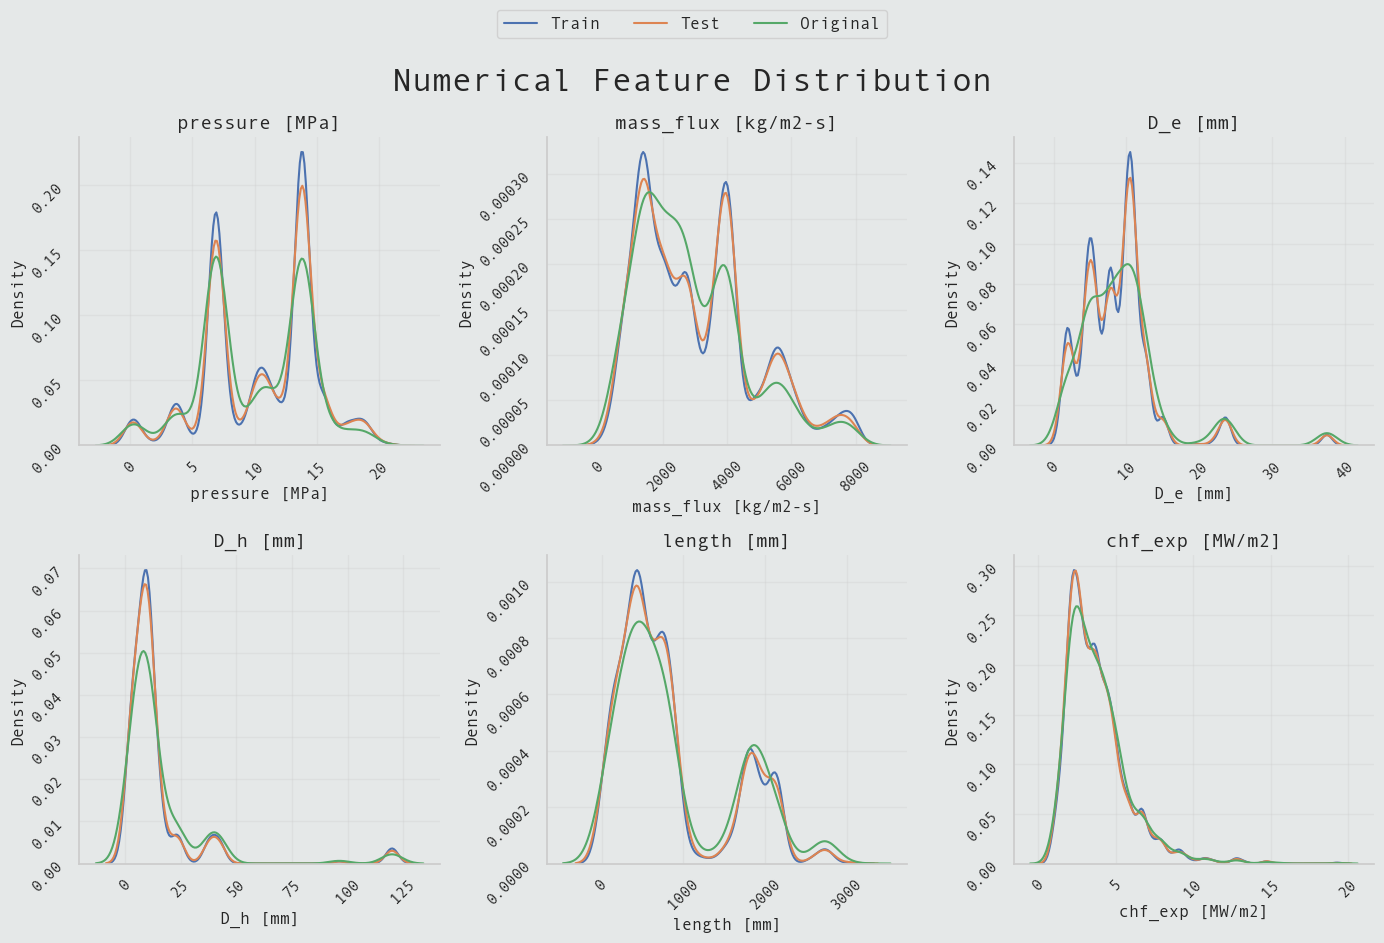

In [28]:
# Plot the KDE of each feature
figure, ax = plt.subplots(2, 3, figsize=(14, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features):
    
    # Plot data
    sns.kdeplot(data=train_data[column_name],
                label='Train',
                ax=ax[index])
    
    sns.kdeplot(data=test_data[column_name],
                label='Test',
                ax=ax[index])
    
    sns.kdeplot(data=original_data[column_name],
                label='Original',
                ax=ax[index])
    
    # Set subplot title
    ax[index].set_title(column_name, fontsize=14)
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

# Set figure Title
figure.suptitle('Numerical Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- `D_h [mm]` and `chf_exp [MW/m2` are strongly right-skewed
- `length [mm]` follows a Binomial distribution
- Since data have different scales, it is required to perform a Data Standardization

### Categorical Feature Distribution

#### Author Distribution

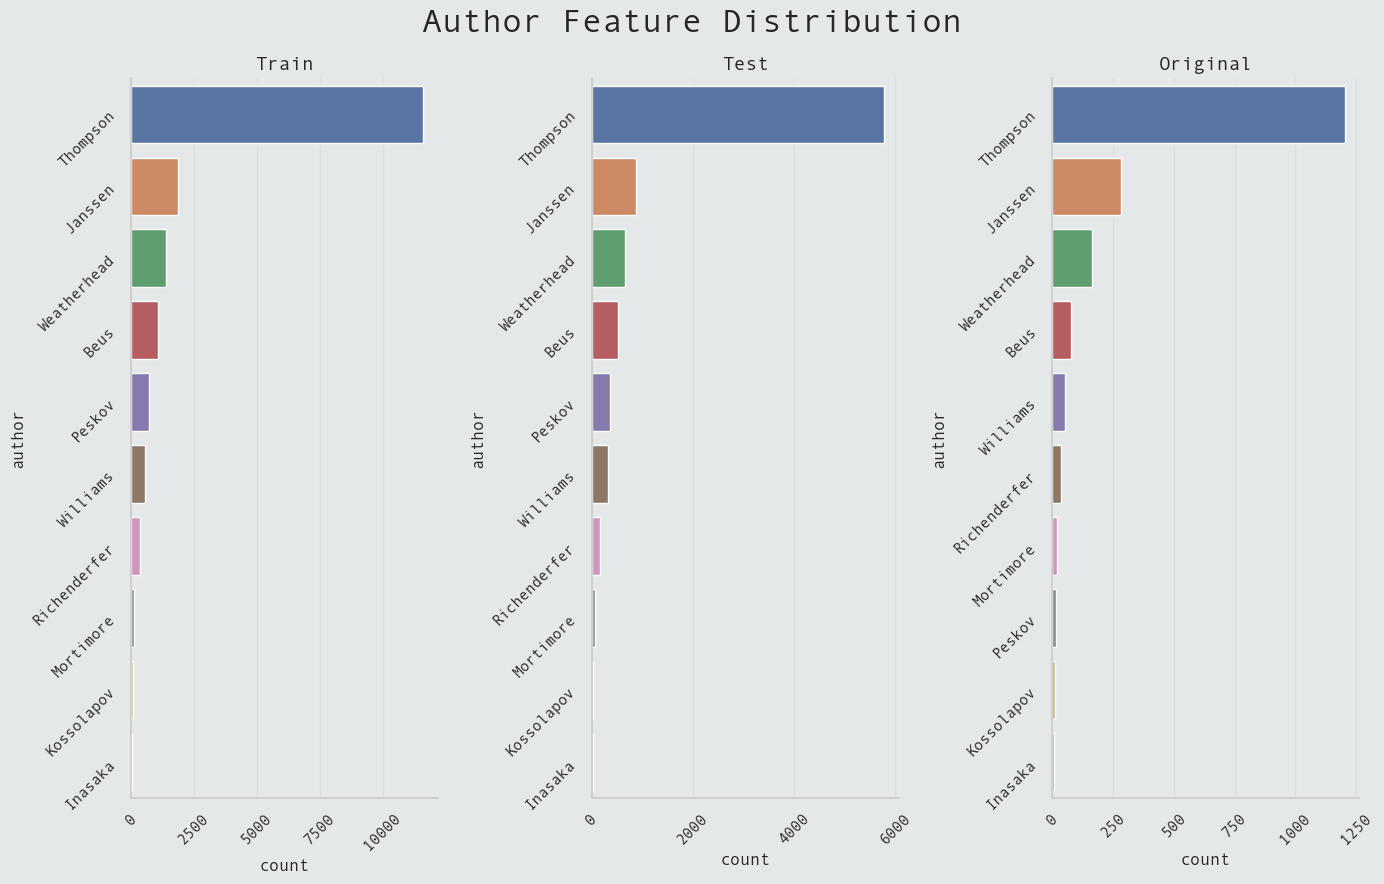

In [34]:
# Plot the countplot for the 'Author' feature
figure, ax = plt.subplots(1, 3, figsize=(14, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Plot data
    sns.countplot(data=data_to_plot[dataset_name],
                  y='author',
                  label=dataset_name,
                  order=data_to_plot[dataset_name]['author'].value_counts().index,
                  ax=ax[index])

    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Set subplot title
    ax[index].set_title(f'{dataset_name}', 
                        fontsize=14)

# Set figure Title
figure.suptitle('Author Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

There's a huge imbalanced distribution in such a feature.

#### Geometry Distribution

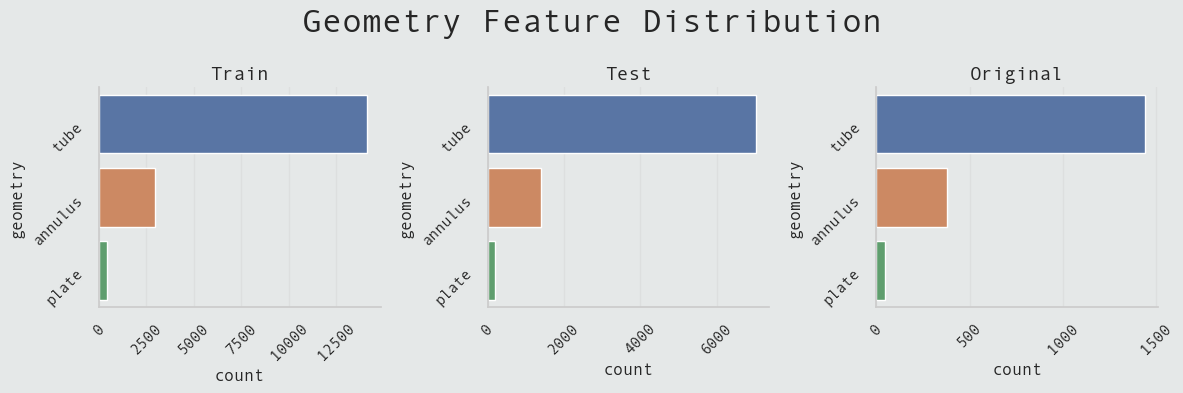

In [38]:
# Plot the countplot for the 'Geometry' feature
figure, ax = plt.subplots(3, 3, figsize=(12, 4))
ax = ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Plot data
    sns.countplot(data=data_to_plot[dataset_name],
                  y='geometry',
                  label=dataset_name,
                  order=data_to_plot[dataset_name]['geometry'].value_counts().index,
                  ax=ax[index])

    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Set subplot title
    ax[index].set_title(f'{dataset_name}', 
                        fontsize=14)

# Set figure Title
figure.suptitle('Geometry Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

### Feature Distribution per Author

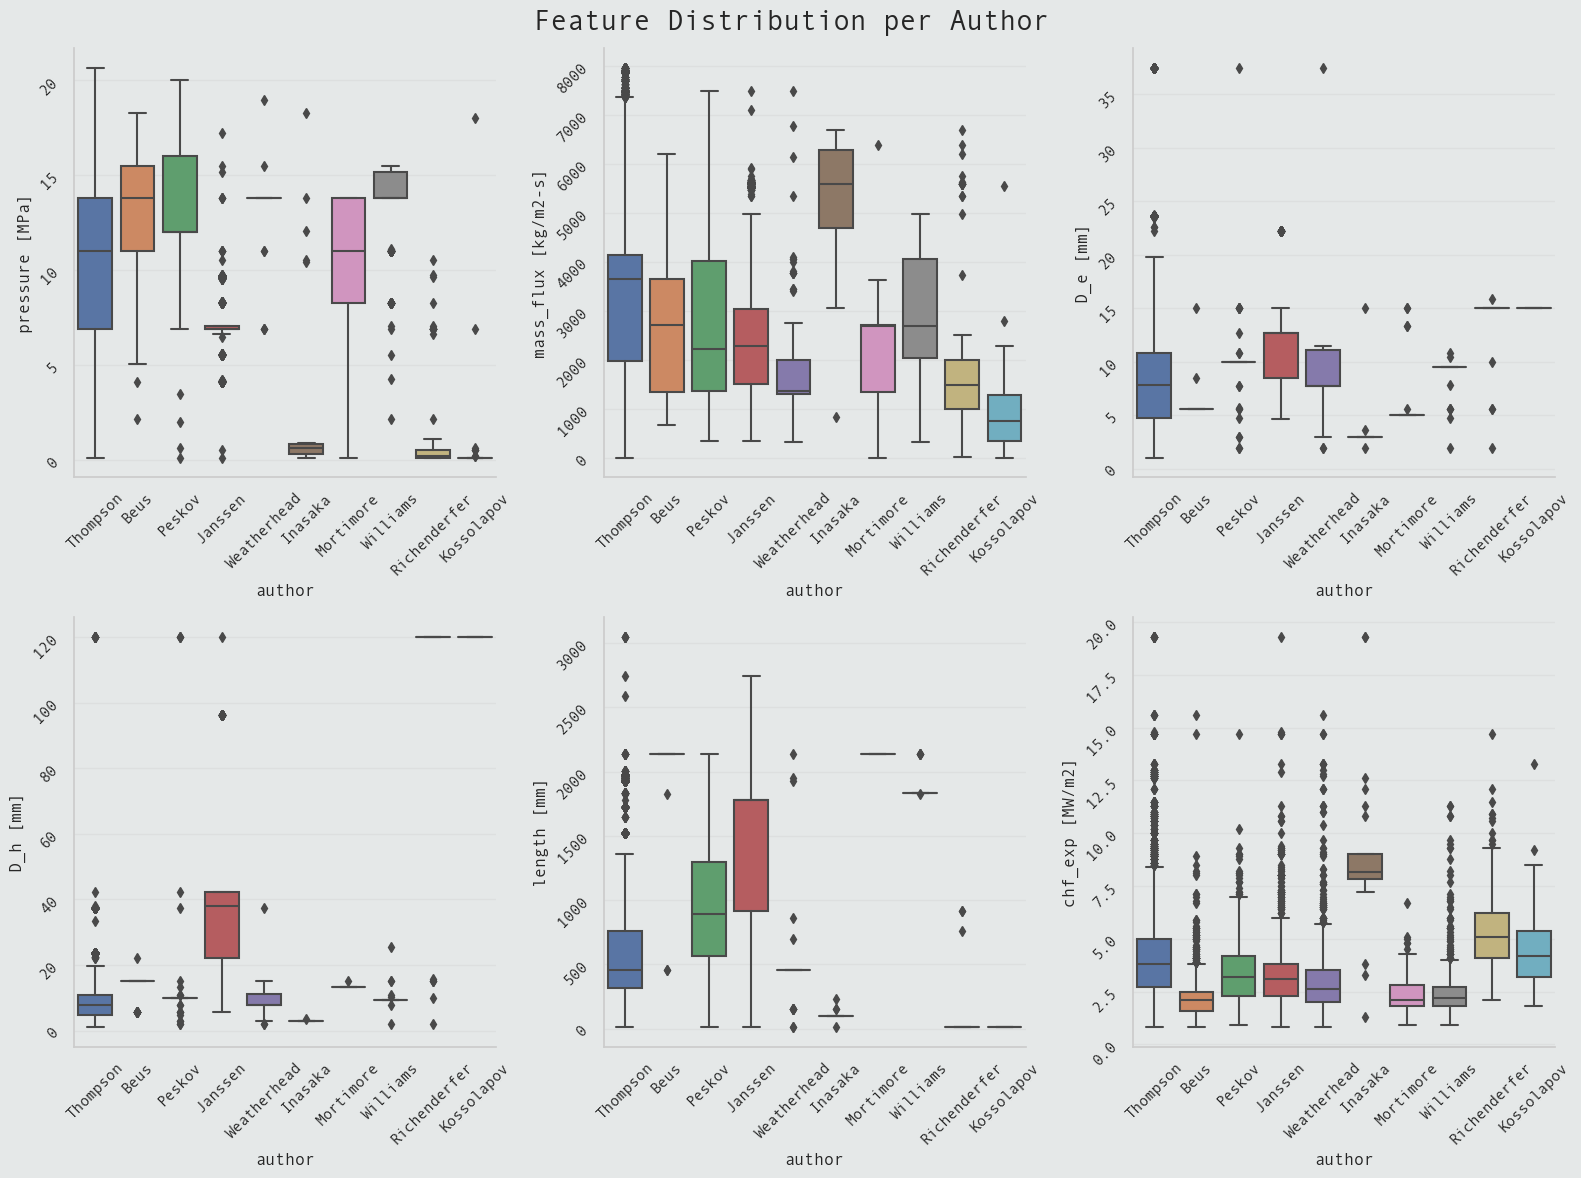

In [56]:
# Define figure and axes
figure, ax = plt.subplots(2, 3, figsize=(16, 12))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(train_data[raw_numerical_features]):
    
    # Plot data
    sns.boxplot(data=train_data,
                x='author',
                y=column_name,
                ax=ax[index])
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)

# Set figure Title
figure.suptitle('Feature Distribution per Author',
                fontweight='bold',
                fontsize=20)

plt.tight_layout()

There is no correlation between th `author` and the other features. Not include it in the feature list.

### Feature Distribution per Geometry

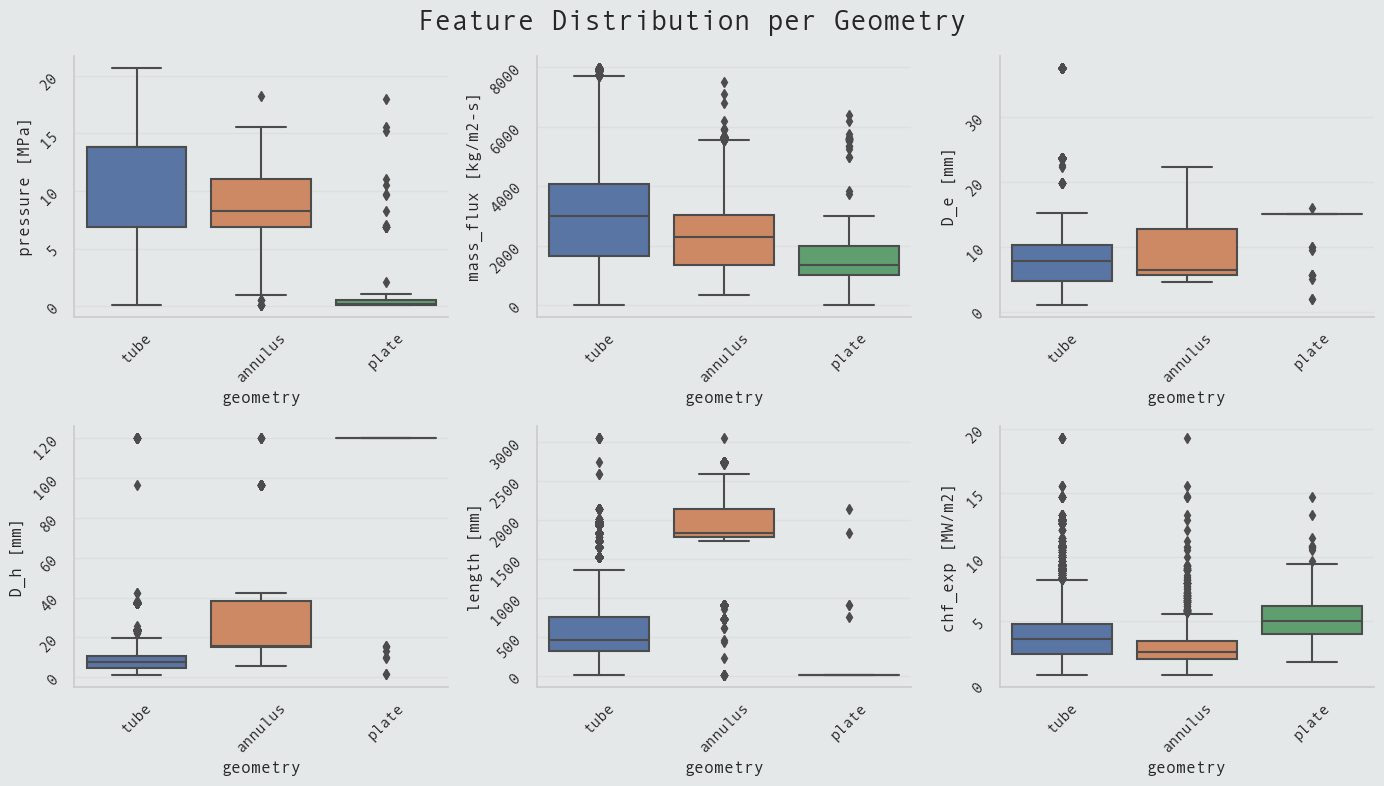

In [68]:
# Define figure and axes
figure, ax = plt.subplots(2, 3, figsize=(14, 8))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(train_data[raw_numerical_features]):
    
    # Plot data
    sns.boxplot(data=train_data,
                x='geometry',
                y=column_name,
                ax=ax[index])
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)

# Set figure Title
figure.suptitle('Feature Distribution per Geometry',
                fontweight='bold',
                fontsize=20)

plt.tight_layout()

Features are very different with respect to the geometry. It's important to include it as a feature

## Label Distribution

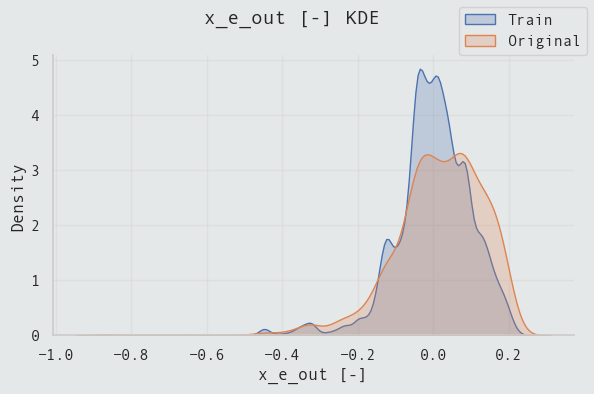

In [60]:
# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot the KDE of label
sns.kdeplot(data=train_data['x_e_out [-]'], 
            fill=True,
            label='Train')

sns.kdeplot(data=original_data['x_e_out [-]'], 
            fill=True,
            label='Original')

# Set figure title
figure.suptitle('x_e_out [-] KDE', fontsize=14)

figure.legend()

plt.tight_layout()

They have the same distribution between Train and Original dataset.

## Pearson Correlation

In [43]:
# Define raw numerical features
correlation_raw_numerical_features = ['pressure [MPa]',
                                      'mass_flux [kg/m2-s]',
                                      'D_e [mm]', 
                                      'D_h [mm]', 
                                      'length [mm]', 
                                      'chf_exp [MW/m2]', 
                                      'x_e_out [-]']

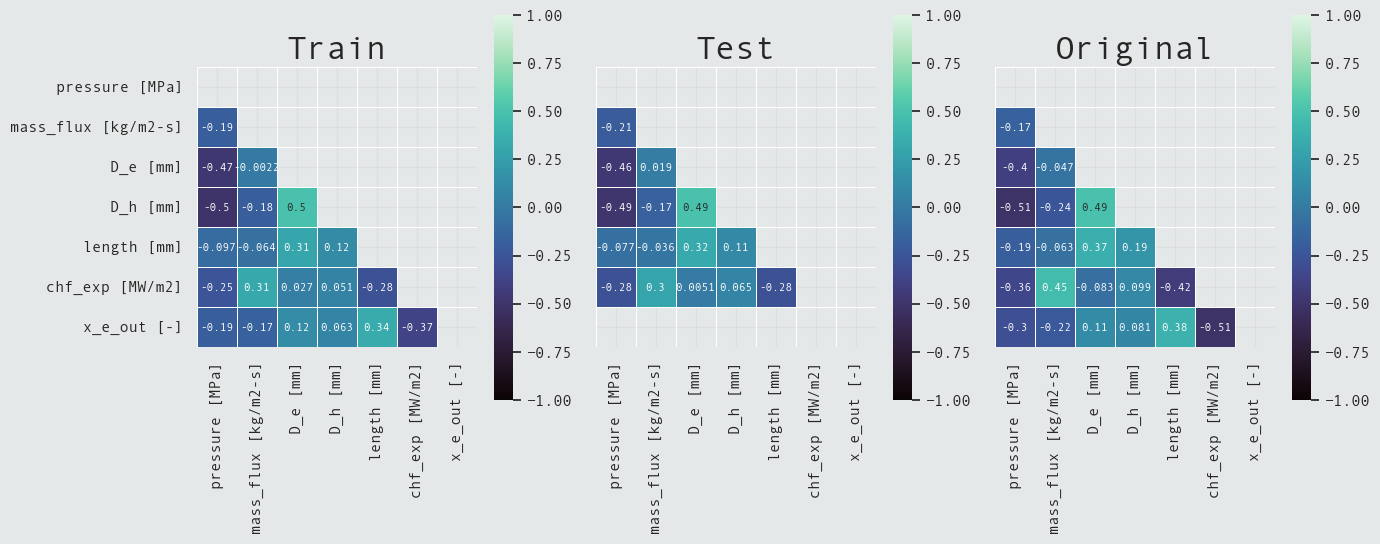

In [64]:
# Define figure and axis
figure, ax = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Compute the correlation matrix
    correlation_matrix = data_to_plot[dataset_name][correlation_raw_numerical_features].corr()
    
    # Generate a mask for the upper triangle
    correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot the correlation matrix
    sns.heatmap(correlation_matrix, 
                mask=correlation_mask, 
                cmap='mako',
                vmax=1.0, 
                vmin=-1.0, 
                center=0, 
                square=True, 
                linewidths=.5, 
                annot=True,
                annot_kws={'fontsize': 8},
                cbar_kws={"shrink":.8, 'orientation':'vertical'}, 
                ax=ax[index])

    # Set title
    ax[index].set_title(f'{dataset_name}',
                        fontweight='bold')


plt.tight_layout()

- Negative linear correlation between `D_e [mm]` and `pressure [MPa]`
- Negative linear correlation between `D_h [mm]` and `pressure [MPa]`
- Positive linear correlation between `D_h [mm]` and `D_e [mm]`

## Spearman Correlation

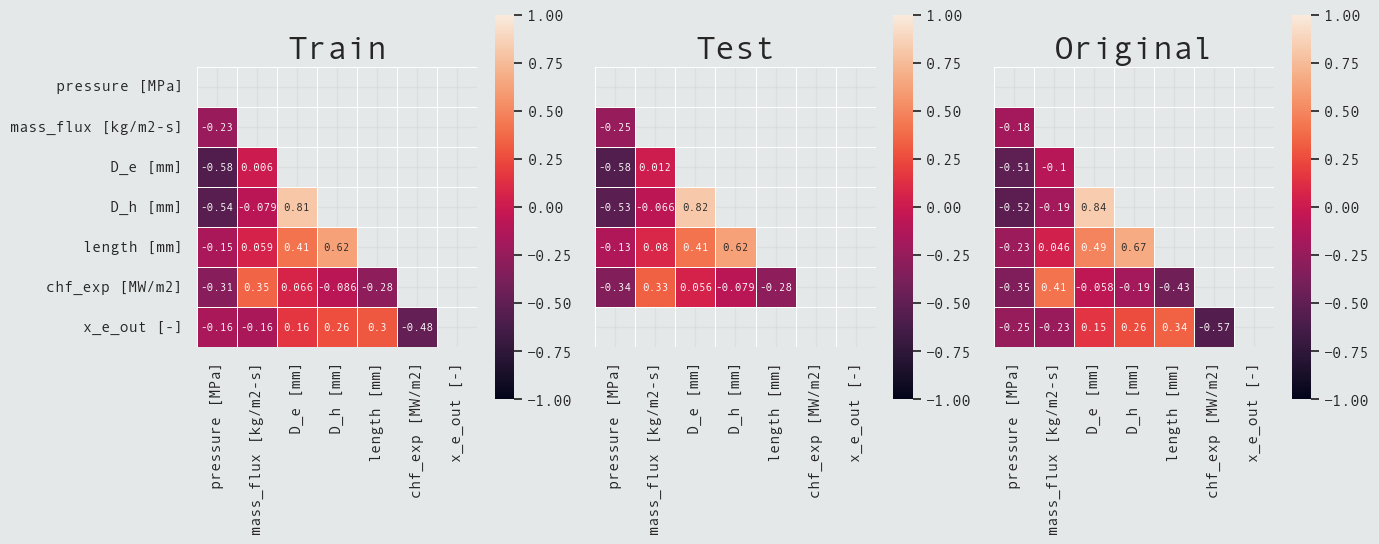

In [70]:
# Define figure and axis
figure, ax = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Compute the correlation matrix
    correlation_matrix = data_to_plot[dataset_name][correlation_raw_numerical_features].corr(method='spearman')
    
    # Generate a mask for the upper triangle
    correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot the correlation matrix
    sns.heatmap(correlation_matrix, 
                mask=correlation_mask, 
                cmap='rocket',
                vmax=1.0, 
                vmin=-1.0, 
                center=0, 
                square=True, 
                linewidths=.5, 
                annot=True,
                annot_kws={'fontsize': 8},
                cbar_kws={"shrink":.8, 'orientation':'vertical'}, 
                ax=ax[index])

    # Set title
    ax[index].set_title(f'{dataset_name}',
                        fontweight='bold')


plt.tight_layout()

- Positive non-linear correlation between `length [mm]` and `D_h [mm]`

## Conclusions 

- Perform column names data cleaning
- Impute null values
- Standardise numerical features since they have different ranges  
- Normalize the numerical features since their distributions are too different 
- One-hot Encoder for `geometry`
- Do not include `author`
- Negative linear correlation between `D_e` and `pressure` > Create `D_e over pressure`
- Negative linear correlation between `D_h` and `pressure` > Create `D_h over pressure`
- Positive linear correlation between `D_h` and `D_e` > Create `D_h per D_e`
- Positive non-linear correlation between `length` and `D_h` > Create `length per D_h`

# Data Preparation

## Data Cleaning

In [45]:
# Define pattern to pass to the regex 
pattern = r'\s\[.*?\]'

# Rename columns
train_data_cleaned = train_data.rename(columns=lambda x: re.sub(pattern, '', x))
test_data_cleaned = test_data.rename(columns=lambda x: re.sub(pattern, '', x))
original_data_cleaned = original_data.rename(columns=lambda x: re.sub(pattern, '', x))

## Feature Engineering

In [34]:
class ComputeNumericalEngineeredFeatures(BaseEstimator, TransformerMixin):
    """
    Create a pre-defined set of engineered feature to the input DataFrame
    """
    
    def fit( self, X, y = None ):
        """
        This method is not required for this transformer
        """
        return self
    
    def transform(self, X):
    
        # Create a feature `D_e over pressure`
        X['D_e over pressure'] = X['D_e'] / X['pressure']

        # Create a feature 'D_h over pressure'
        X['D_h over pressure'] = X['D_h'] / X['pressure']

        # Create a feature 'D_h per D_e'
        X['D_h per D_e'] = X['D_h'] * X['D_e']

        # Create a feature 'length per D_h'
        X['length per D_h'] = X['length'] * X['D_h']
        
        # Save column names
        self.feature_names = X.columns

        return X
    
    def get_feature_names_out(self, feature_names):
        """
        Retrieve the feature names
        """
        return [f'{col}' for col in self.feature_names]

## Data Pipeline

In [35]:
# Dictionary of data transformations to include
data_trasformations = {
    'numerical': {
        'feature_engineering': True,
        'imputation': True,
        'standardization': True,
        'normalization': True
    },
    'categorical': {
        'imputation': True,
        'one_hot_encoding': True,
    }
}

### Numerical Data Pipeline

In [36]:
class Log1pTransformer(BaseEstimator, TransformerMixin):
    """
    Implements a Numpy.log1p transformation for Scikit-Learn Pipeline
    """
    
    def fit(self, X, y=None):
        """
        This method is not required for this transformer
        """
        return self
    
    def transform(self, X):
        """
        Transform the data X with a Numpy.log1p transformation
        """
        # Apply np.log1p to the input array
        return np.log1p(X, where=True)
    
    def get_feature_names_out(self, feature_names):
        """
        Retrieve the feature names
        """
        return [f'{col}' for col in feature_names]

In [37]:
# Define numerical features
numerical_features = [
    'pressure', 
    'mass_flux', 
    'D_e', 
    'D_h', 
    'length', 
    'chf_exp'
]

In [38]:
# Define the numerical data pipeline steps based on data_trasformations['numerical']
numerical_data_pipeline_steps = []

if data_trasformations['numerical']['feature_engineering']:
    numerical_data_pipeline_steps.append(('feature_engineering', ComputeNumericalEngineeredFeatures()))
if data_trasformations['numerical']['imputation']:
    numerical_data_pipeline_steps.append(('imputation', SimpleImputer(strategy='median', copy=False)))
if data_trasformations['numerical']['standardization']:
    numerical_data_pipeline_steps.append(('standardization', MinMaxScaler()))
if data_trasformations['numerical']['normalization']:
    numerical_data_pipeline_steps.append(('normalization', Log1pTransformer()))

### Categorical Data Pipeline

In [39]:
# Define categorical features
categorical_features = [
    'geometry'
]

In [40]:
# Define the categorical data pipeline steps based on data_trasformations['categorical']
categorical_data_pipeline_steps = []

if data_trasformations['categorical']['imputation']:
    categorical_data_pipeline_steps.append(('imputation', SimpleImputer(strategy='most_frequent', copy=False)))
if data_trasformations['categorical']['one_hot_encoding']:
    categorical_data_pipeline_steps.append(('one_hot_encoding', OneHotEncoder()))

### Bunlde the Data Pipeline

In [41]:
# Define the data preparation transformations
data_preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline(numerical_data_pipeline_steps), numerical_features),
        ('categorical', Pipeline(categorical_data_pipeline_steps), categorical_features),
    ])

## Features and Label Definition

In [46]:
# Define the features to include
features = numerical_features + categorical_features

# Define the labels to include
labels = ['x_e_out']

# Train & Test Split

In [47]:
# Define X and y for the training set
if include_original_data:
    X = pd.concat([train_data_cleaned[features], original_data_cleaned[features]], axis=0)
    y = np.ravel(pd.concat([train_data_cleaned[labels], original_data_cleaned[labels]], axis=0))
else:
    X = train_data_cleaned[features]
    y = np.ravel(train_data[labels])

In [50]:
# Split training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=108)

# Model Training

In [51]:
# Set MLflow Experiment
mlflow_experiment_name = 'Heat Flux Feature Imputation'

# Create experiment or retrieve already existing experiment
try:
    mlflow_experiment_id = mlflow.create_experiment(name=mlflow_experiment_name)
except Exception as e:
    mlflow_experiment_id = mlflow.get_experiment_by_name(mlflow_experiment_name).experiment_id

In [53]:
# Define trained models
models = {}

In [54]:
# Define the used metrics
metrics = ['RMSE', 'MSE', 'MAE', 'MAPE', 'R2 Score']

In [55]:
# Initialize DataFrame of model performance
performance = pd.DataFrame(columns=metrics)

## Linear Regression

In [58]:
%%time

# Start MLflow Run
with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                      run_name='Linear Regression'):
    # Define the model
    model_lr = LinearRegression()

    # Define the pipeline
    pipe_lr = Pipeline([
        ('data_preprocessing', data_preprocessor),
        ('linear_regression', model_lr)
    ])
    
    # Train the pipeline
    pipe_lr.fit(X_train, 
                y_train)

    # Get predictions
    predictions_lr = pipe_lr.predict(X_test)

    # Compute metrics
    rmse_lr = round(mean_squared_error(y_test, predictions_lr) ** 0.5, 4)
    mse_lr = round(mean_squared_error(y_test, predictions_lr), 4)
    mae_lr = round(mean_absolute_error(y_test, predictions_lr), 4)
    mape_lr = round(mean_absolute_percentage_error(y_test, predictions_lr), 4)
    r2_score_lr = round(r2_score(y_test, predictions_lr), 4)

    print('RMSE: {}'.format(rmse_lr))
    print('MSE: {}'.format(mse_lr))
    print('MAE: {}'.format(mae_lr))
    print('MAPE: {}'.format(mape_lr))
    print('R2 Score: {}'.format(r2_score_lr))
    print('\n')
    
    # Log model's evaluation metrics
    mlflow.log_metrics({'RMSE': rmse_lr, 
                        'MSE': mse_lr, 
                        'MAE': mae_lr, 
                        'MAPE': mape_lr, 
                        'R2': r2_score_lr})
    
    # Log model's features
    mlflow.log_params({'Features': features, 
                       'Data Transformations': data_trasformations,
                       'Include Original Dataset': include_original_data})

RMSE: 0.0863
MSE: 0.0075
MAE: 0.0626
MAPE: 3.0241
R2 Score: 0.2902


CPU times: user 107 ms, sys: 50.4 ms, total: 157 ms
Wall time: 86.4 ms


In [60]:
# Update 'performance' DataFrame
performance.loc['Logistic Regression'] = [rmse_lr, mse_lr, mae_lr, mape_lr, r2_score_lr]

In [61]:
# Add the trained model to the list of models
models['Linear Regression'] = pipe_lr

## Random Forest Regressor

In [63]:
# Random Forest Regressor Hyperparameters
hyperparameters_rfr = {
    'n_estimators': 50,
    'criterion': 'squared_error',
    'max_depth': 9,
    'min_samples_split': 10,
    'min_samples_leaf': 10
}

In [64]:
%%time

# Start MLflow Run
with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                      run_name='Random Forest Regressor'):
    # Define the model
    model_rfr = RandomForestRegressor(**hyperparameters_rfr)

    # Define the pipeline
    pipe_rfr = Pipeline([
        ('data_preprocessing', data_preprocessor),
        ('random_forest_regressor', model_rfr)
    ])

    # Train the pipeline
    pipe_rfr.fit(X_train,
                 y_train)

    # Get predictions
    predictions_rfr = pipe_rfr.predict(X_test)

    # Compute metrics
    rmse_rfr = round(mean_squared_error(y_test, predictions_rfr) ** 0.5, 4)
    mse_rfr = round(mean_squared_error(y_test, predictions_rfr), 4)
    mae_rfr = round(mean_absolute_error(y_test, predictions_rfr), 4)
    mape_rfr = round(mean_absolute_percentage_error(y_test, predictions_rfr), 4)
    r2_score_rfr = round(r2_score(y_test, predictions_rfr), 4)

    print('RMSE: {}'.format(rmse_rfr))
    print('MSE: {}'.format(mse_rfr))
    print('MAE: {}'.format(mae_rfr))
    print('MAPE: {}'.format(mape_rfr))
    print('R2 Score: {}'.format(r2_score_rfr))
    print('\n')
    
    # Log model's evaluation metrics
    mlflow.log_metrics({'RMSE': rmse_rfr, 
                        'MSE': mse_rfr, 
                        'MAE': mae_rfr, 
                        'MAPE': mape_rfr, 
                        'R2': r2_score_rfr})
    
    # Log model's features
    mlflow.log_params({'Features': features, 
                       'Include Original Dataset': include_original_data})

RMSE: 0.0742
MSE: 0.0055
MAE: 0.0516
MAPE: 3.1684
R2 Score: 0.4751


CPU times: user 1.06 s, sys: 31.1 ms, total: 1.09 s
Wall time: 1.12 s


In [66]:
# Update 'performance' DataFrame
performance.loc['Random Forest Regressor'] = [rmse_rfr, mse_rfr, mae_rfr, mape_rfr, r2_score_rfr]

In [67]:
# Add the trained model to the list of models
models['Random Forest Regressor'] = pipe_rfr

# Model Explanability

## Model Comparison

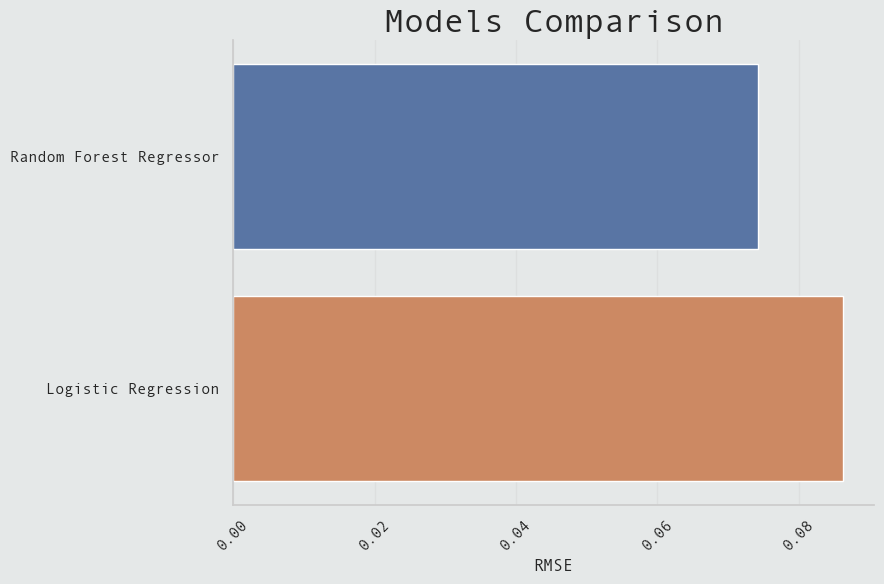

In [68]:
# Sort dataframe by the metric
performance.sort_values('RMSE', inplace=True)

# Create figure
figure = plt.figure(tight_layout=True, figsize=(9, 6))

# Plot models' metrics
ax = sns.barplot(data=performance, 
                 x='RMSE', 
                 y=performance.index.tolist())

# Set title
ax.set_title('Models Comparison', 
             fontsize=24)

# Set tick rotation
plt.xticks(rotation=45)

# Plot with tight layout
plt.tight_layout()

- Random Forest Regressor performs better in terms of RMSE

## Feature Importance

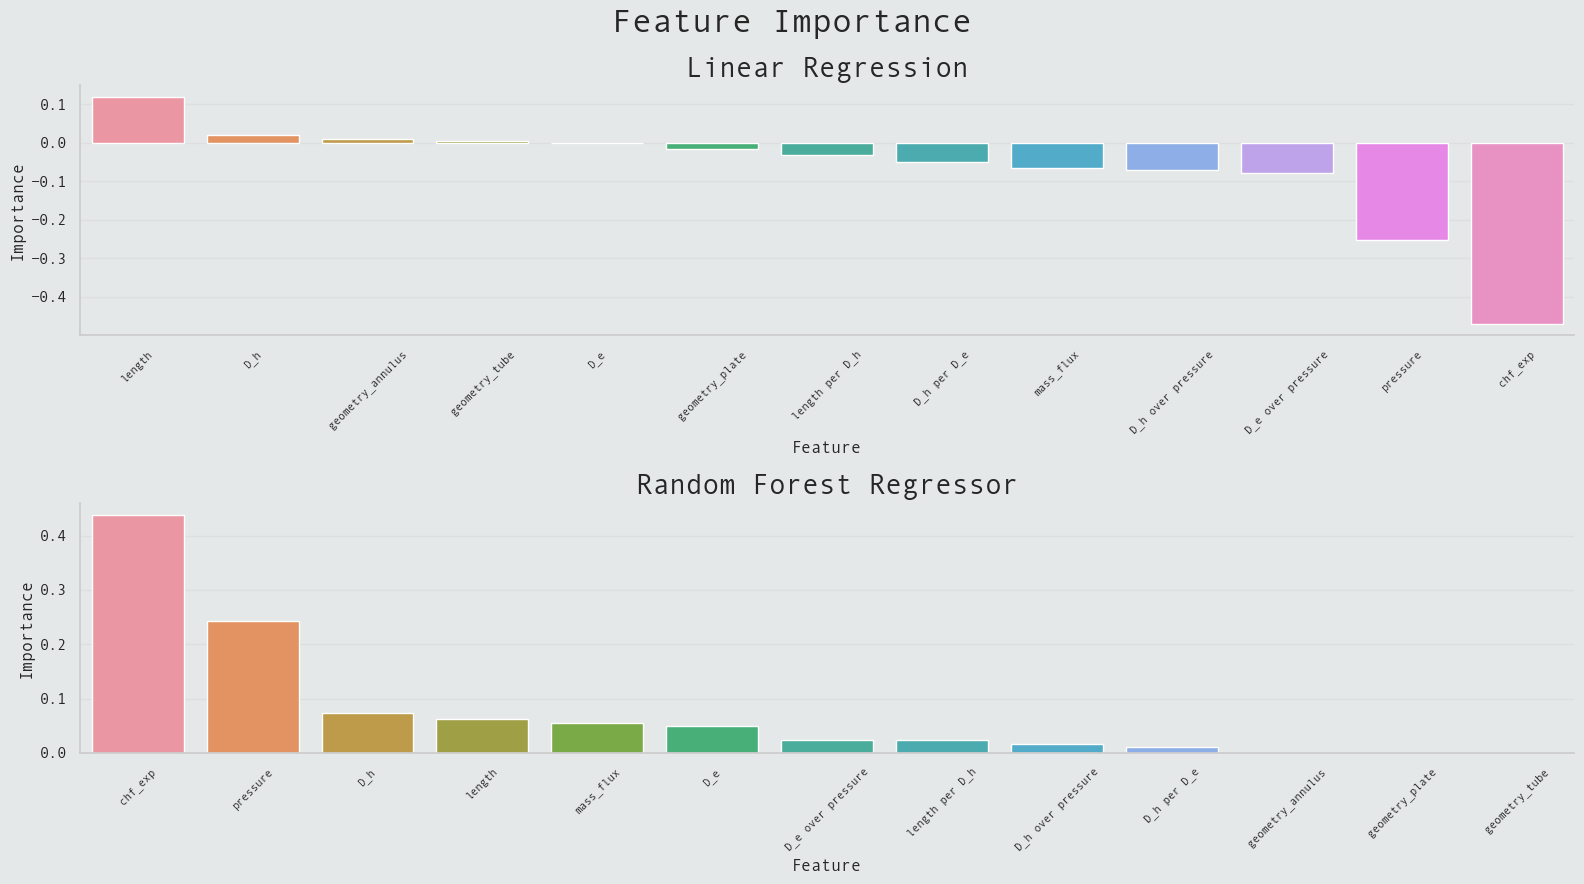

In [112]:
# Define figure and axes
figure, ax = plt.subplots(2, 1, figsize=(16, 9))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Retrieve feature names
    feature_names = models[model_name].named_steps['data_preprocessing'].get_feature_names_out()
    
    # Refactor feature names to remove the ColumnTransformer prefix
    feature_names = [feature_name.split('__')[-1] for feature_name in feature_names]
    
    # Retrieve pipeline model's step name
    pipe_model_step_name = list(models[model_name].named_steps.keys())[-1]
    
    # Retrieve feature importances values
    try:
        # Tree-based models
        feautre_importance_values = models[model_name].named_steps[pipe_model_step_name].feature_importances_
    except:
        # Regression-based models
        feautre_importance_values = models[model_name].named_steps[pipe_model_step_name].coef_.reshape(-1,)
        
    
    
    # Compute the feature importance
    feature_importance = sorted(list(zip(feature_names,
                                         feautre_importance_values)),
                                key=lambda x: x[1], reverse=True)

    # Transform it into a DataFrame
    feature_importance_df = pd.DataFrame(feature_importance,
                                         columns= ['Feature', 'Importance'])    
    
    # Plot the feature importance
    sns.barplot(data=feature_importance_df,
               x='Feature',
               y='Importance', 
               ax=ax[index])

    # Set title
    ax[index].set_title(model_name, 
                 fontsize=20)

    # Refine x labels
    ax[index].set_xticklabels(feature_importance_df['Feature'],
                              fontsize=8,
                              rotation=45)

# Define figure title
figure.suptitle('Feature Importance',
                fontweight='bold',
                fontsize=24)

# Plot with tight layout
plt.tight_layout()

- The original dataset label has a huge impact on the feature imputation. It makes sense, since it is probably inferenced from the feature

## Learning Curves

In [116]:
# Define Learning Curves Display parameters
learning_curves_display_paramters = {
    'X': X,
    'y': y,
    'cv': ShuffleSplit(n_splits=3, test_size=0.3, random_state=108),
    'train_sizes': np.linspace(0.1, 1.0, 8),
    'scoring': 'neg_root_mean_squared_error',
    'negate_score': True,
    'score_name': 'RMSE',
    'score_type': 'both',
    'verbose': 0,
    'line_kw': {'marker': 'o'},
    'std_display_style': 'fill_between',
}

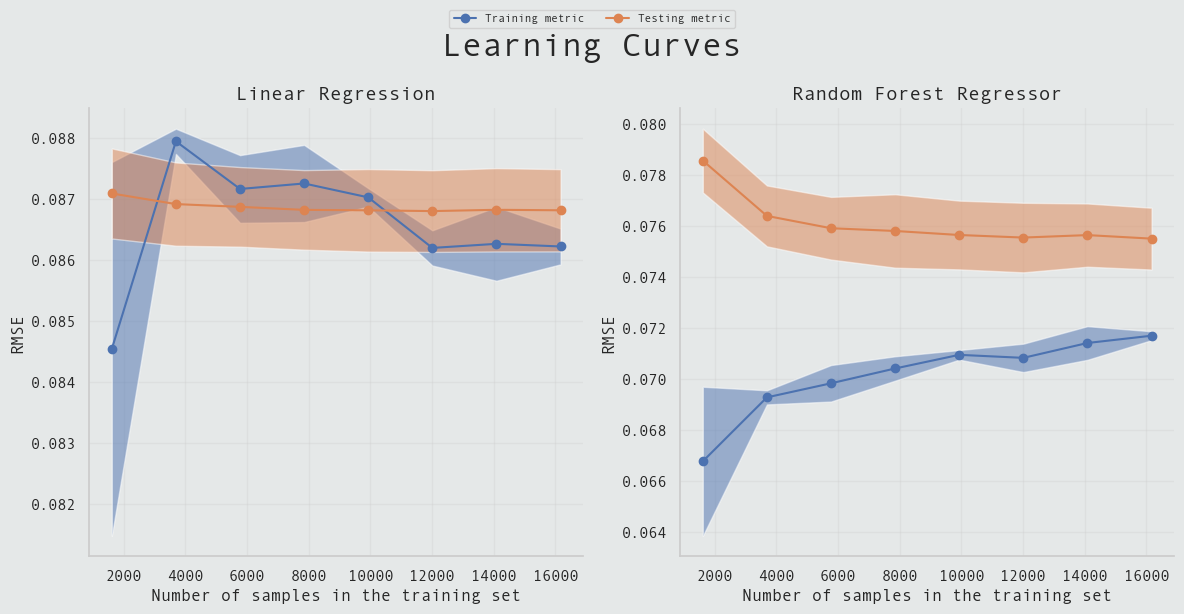

In [117]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):

    # Plot the Learning Curve
    LearningCurveDisplay.from_estimator(models[model_name], 
                                        **learning_curves_display_paramters,
                                        ax=ax[index])
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
    # Set the title
    ax[index].set_title(model_name, fontsize=14)
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=8,
              ncol=2)

# Define figure title
figure.suptitle('Learning Curves',
                fontweight='bold',
                fontsize=24)
    
# Plot with tight layout
plt.tight_layout()

- The Linear Regression has a very bad learning capability

## Residuals

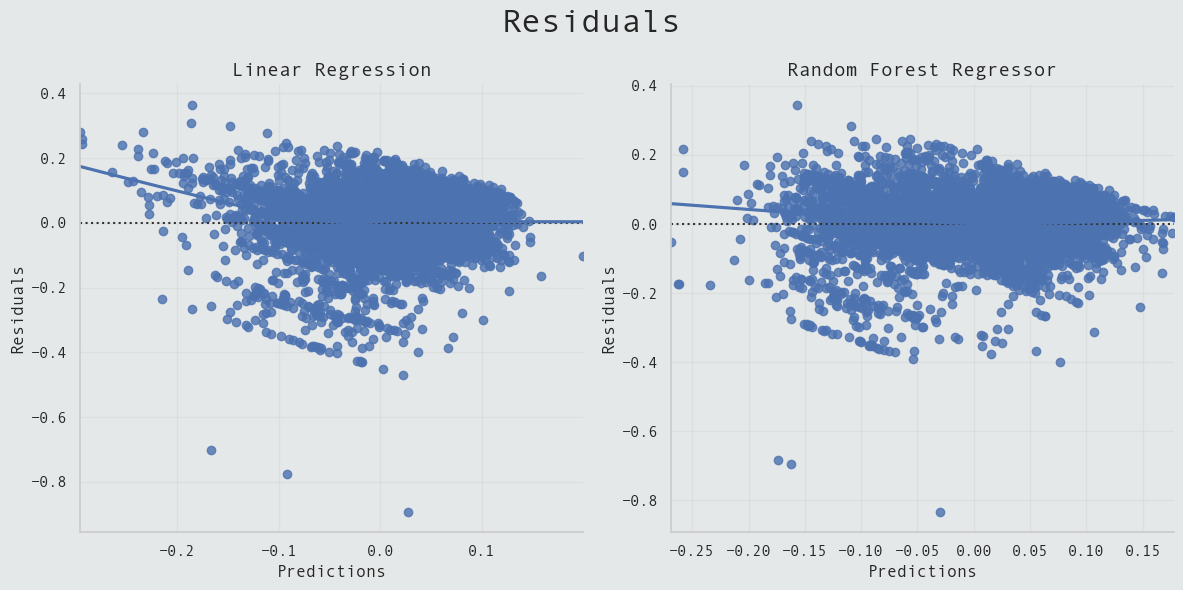

In [118]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Compute the predictions for the test set
    predictions = models[model_name].predict(X_test)
    
    # Reshape predictions
    predictions = predictions.reshape(-1,)
    
    # Compute the residuals
    residuals = y_test - predictions
    
    # Create the Pandas DataFrame
    residuals_df = pd.DataFrame({'Residuals': residuals, 
                                 'Predictions': predictions})
    
    # Plot the residuals
    sns.residplot(x='Predictions', 
                  y='Residuals',
                  data=residuals_df, 
                  ax=ax[index],
                  lowess=True)

    # Set the title
    ax[index].set_title(model_name, fontsize=14)

# Define figure title
figure.suptitle('Residuals',
                fontweight='bold',
                fontsize=24)

# Plot with tight layout
plt.tight_layout()

## Q-Q Plots

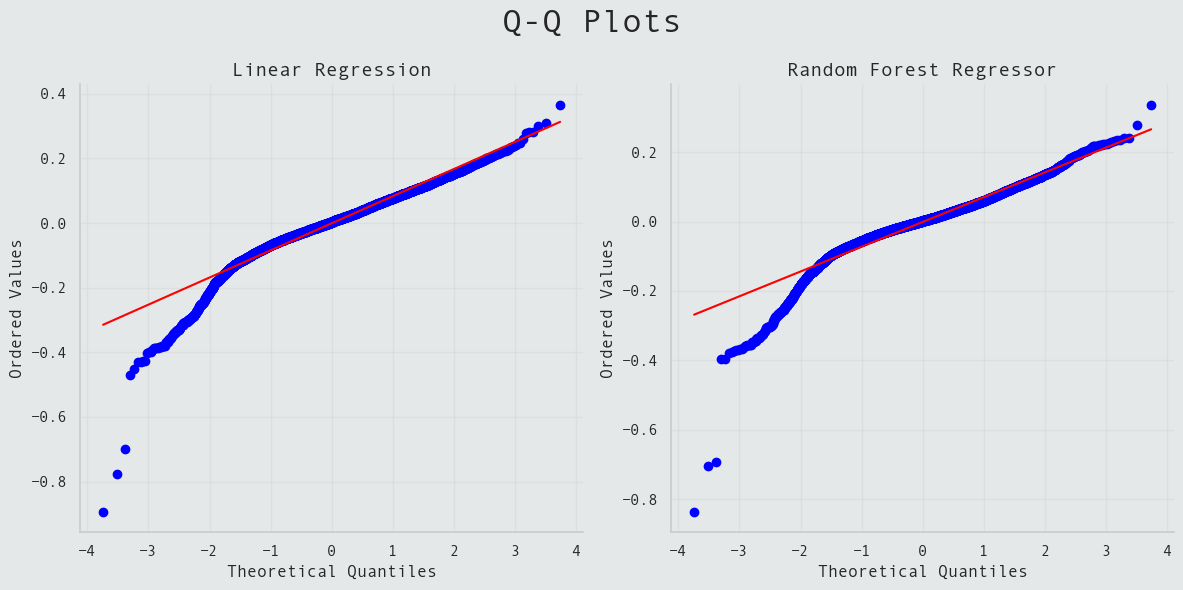

In [121]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Compute the predictions for the test set
    predictions = models[model_name].predict(X_test)
    
    # Reshape predictions
    predictions = predictions.reshape(-1,)
    
    # Compute the residuals
    residuals = y_test - predictions
    
    # Generate a QQ plot
    stats.probplot(residuals, 
                   plot=ax[index])
    
    ax[index].set_xlabel('Theoretical Quantiles')

    # Set the title
    ax[index].set_title(model_name, fontsize=14)
    
    
figure.suptitle('Q-Q Plots',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()